In [1]:
import numpy as np
import pandas as pd

In [33]:
#path = 'M:/My Documents/Business/Property/Statements/processed/' # Network load stopped working so had to copy files to E:
path = 'E:\\dtuklaptop\\e\\Users\\Mat\\python\\data\\property\\processed\\'

def strip(df):
    df['Memo']=df['Memo'].str.strip()
    df['Subcategory']=df['Subcategory'].str.strip()
    if 'Description' in df.columns:
        df['Description']=df['Description'].str.strip()
    return df

def load(spreadsheets):
    dfIv = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    dfMt = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo','Property','Description'])
    df40 = pd.DataFrame(columns=['Date','Account','Amount','Subcategory','Memo'])
    dfRs = pd.DataFrame()
    for spreadsheet in spreadsheets:
        dfMtTemp=load_worksheet(spreadsheet, 'MT')
        dfMt=pd.concat([dfMt,dfMtTemp]) 
        dfIvTemp=load_worksheet(spreadsheet, 'IV')
        dfIv=pd.concat([dfIv,dfIvTemp])
        df40Temp=load_worksheet(spreadsheet, 'IV (4040)')
        df40=pd.concat([df40,df40Temp])
        dfRsTemp=load_rent_statement(spreadsheet)
        dfRs=pd.concat([dfRs,dfRsTemp]) 
    dfMt=strip(dfMt)
    dfIv=strip(dfIv)
    df40=strip(df40)
    
    dfMt=dfMt.loc[:, ~dfMt.columns.str.contains('^Unnamed')]
    dfIv=dfIv.loc[:, ~dfIv.columns.str.contains('^Unnamed')]
    df40=df40.loc[:, ~df40.columns.str.contains('^Unnamed')]
    
    dfMt=dfMt.set_index('Date')
    dfIv=dfIv.set_index('Date')
    df40=df40.set_index('Date')
    return dfMt, dfIv, df40, dfRs

def load_worksheet(spreadsheet, worksheet):
    input_file = path + spreadsheet + '.xlsm'
    df = pd.read_excel(input_file,sheet_name=worksheet)
    df.drop('Import', axis=1, inplace=True)
    df.drop('Number', axis=1, inplace=True)
    df = df.astype({"Description": str})
    df = df[~df.Account.isnull()]
    return df

def load_rent_statement(spreadsheet):
    worksheet='Rent Statement'
    input_file = path + spreadsheet + '.xlsm'
    dfSmtDate = pd.read_excel(input_file,sheet_name=worksheet)
    dfSmtDate=dfSmtDate.loc[dfSmtDate['Rental Statement']=='Statement Date:','Unnamed: 1'].iloc[0]

    df = pd.read_excel(input_file,sheet_name=worksheet,header=6)
    df=df.loc[(df['Owner'].notnull())&(df['Owner']!='Alhambra Road Management Ltd')]
    df=df.loc[(df['Property'].notnull())]
    df=df.loc[:, ~df.columns.str.contains('^Unnamed')]
    
    df['StatementDate'] = dfSmtDate
    df.drop('Reconciled', axis=1, inplace=True)
    df.drop('Lender', axis=1, inplace=True)
    df.drop('Account No', axis=1, inplace=True)
    df.drop('Property Id', axis=1, inplace=True)
    df.drop('Profit', axis=1, inplace=True)
    df.drop('Net Income', axis=1, inplace=True)
       
    df.update(df.select_dtypes(include=[np.number]).fillna(0))
    df['Profit']=df['Rental Amount']-df['Mgmt Fees']-df['VAT']-df['Bills Paid']-df['Other Bills']
    df['Net Income']=df['Profit']-df['Mortgage Payment']

    return df

def categorise(df):
    # Categorise expenses
    # Mortgage, PropertyExpense, OurRent, BealsRent, ServiceCharge
    # SchoolFees, Car, Hilltop, PersonalExpenses, RegularPayment
    global dfUncat
    df["Cat"] = np.nan
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('JASPER|TOPAZ|SIBERITE|MORTGAGE EXPRESS|NRAM|PLATFORM|AMBER|BHAM|CAPITAL|CHL|MORTGAGE TRUST')==True),"Cat"] = 'Mortgage'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*M TUCKER.*STO.*')==True) & (df.Amount > -200) & (df.Amount <-190),"Cat"] = 'Mortgage' # Kingston Rd mortgage
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Description.str.match('Rent for period')==True),"Cat"] = 'OurRent'
    df.loc[(df.Cat.isnull())&(df.Description.notnull())&(df.Property.notnull()) & (df.Description.str.match('Rent for period')==False),"Cat"] = 'PropertyExpense'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('BEALS.*BGC')==True),"Cat"] = 'BealsRent'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('23 HAMPSHIRE.*STO|4-6 ALHAMBRA RD CS|12-14 ALHAMBRA RD|16-18 ALHAMBRA RD|ALHAMBRA ROAD MANA')==True),"Cat"] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*HARPUR TRUST.*|.*BEDFORD SCHOOL.*')==True),"Cat"] = 'SchoolFee'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*F VALENTINO.*')==True),"Cat"] = 'Hilltop'
    
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('HMRC')==True),"Cat"] = 'HMRC'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT')&(df.Memo.str.match('CCTV|Letterbox',case=False)==True),"Cat"] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='PAYMENT'),"Cat"] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CASH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CRE'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='OTH'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='BCC'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REFUND'),'Cat'] = 'PersonalExpense'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='CHQ'),'Cat'] = 'PersonalExpense'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*INTERCO.*',case=False)==True),'Cat'] = 'ServiceCharge'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Description.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*13438023.*|.*83672832.*|.*23534332.*|.*13686035.*')==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*Alham.*|.*HAG.*',case=False)==True),'Cat'] = 'AlhambraPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('.*63796884.*|.*33631583.*',case=False)==True),'Cat'] = 'ServiceCharge'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*LAND ROVER.*')==True),"Cat"] = 'Car'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='DIRECTDEBIT'),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('NATIONWIDE|KINGSTON UNITY')==True),'Cat'] = 'RegularPayment'
    df.loc[(df.Cat.isnull())&(df.Subcategory=='REPEATPMT')&(df.Memo.str.match('.*M TUCKER.*STO.*')==True)&(df.Amount>-100),'Cat'] = 'RegularPayment'

    df.loc[(df.Cat.isnull())&(df.Subcategory=='FT')&(df.Memo.str.match('Sofia|Rocco', case=False)==True),'Cat'] = 'Kids'
    
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*30728691.*')==True),'Cat'] = 'Funds3072'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*40406538 .*')==True),'Cat'] = 'Funds4040'
    df.loc[(df.Cat.isnull())&(df.Memo.str.match('.*60458872.*')==True),'Cat'] = 'Funds6045'

    df.loc[(df.Cat.isnull())&(df.Amount>0),'Cat'] = 'OtherIncome'
    df.loc[(df.Cat.isnull())&(df.Amount<0),'Cat'] = 'OtherExpense'

    return df

def sumOf(df,cat):
    g=pd.Grouper(freq="M")
    return df.loc[df.Cat == cat,'Amount'].groupby(g).sum()

def get_rent_statement_summary(dfRs):
    #dfSum = pd.DataFrame()
    dfSum=dfRs.groupby(['StatementDate']).sum()
    return dfSum

def get_pty_summary(dfMt,dfIv):
    dfPty = pd.DataFrame()
    dfPty['Mortgage']=pd.concat([sumOf(dfMt,'Mortgage'),sumOf(dfIv,'Mortgage')],axis=1).sum(axis=1)
    dfPty['PropertyExpense']=pd.concat([sumOf(dfMt,'PropertyExpense'),sumOf(dfIv,'PropertyExpense')],axis=1).sum(axis=1)
    dfPty['ServiceCharge']=pd.concat([sumOf(dfMt,'ServiceCharge'),sumOf(dfIv,'ServiceCharge')],axis=1).sum(axis=1)
    dfPty['OurRent']=pd.concat([sumOf(dfMt,'OurRent'),sumOf(dfIv,'OurRent')],axis=1).sum(axis=1)
    dfPty['BealsRent']=pd.concat([sumOf(dfMt,'BealsRent'),sumOf(dfIv,'BealsRent')],axis=1).sum(axis=1)
    
    dfPty = dfPty.fillna(0)
    
    dfPty['TotalRent']=dfPty['OurRent'] + dfPty['BealsRent']
    dfPty['NetProfit']=dfPty['OurRent'] + dfPty['BealsRent'] + dfPty['Mortgage'] + dfPty['PropertyExpense'] + dfPty['ServiceCharge']
    return dfPty

def get_outgoings(dfPty,dfMt,dfIv,df40):
    dfOut = pd.DataFrame()
    dfOut['NetProfit']=dfPty['NetProfit']
    dfOut['SchoolFee']=pd.concat([sumOf(dfMt,'SchoolFee'),sumOf(dfIv,'SchoolFee'),sumOf(df40,'SchoolFee')],axis=1).sum(axis=1)
    dfOut['Hilltop']=pd.concat([sumOf(dfMt,'Hilltop'),sumOf(dfIv,'Hilltop'),sumOf(df40,'Hilltop')],axis=1).sum(axis=1)
    dfOut['Car']=pd.concat([sumOf(dfMt,'Car'),sumOf(dfIv,'Car'),sumOf(df40,'Car')],axis=1).sum(axis=1)
    dfOut['RegularPayment']=pd.concat([sumOf(dfMt,'RegularPayment'),sumOf(dfIv,'RegularPayment'),sumOf(df40,'RegularPayment')],axis=1).sum(axis=1)
    dfOut['PersonalExpense']=pd.concat([sumOf(dfMt,'PersonalExpense'),sumOf(dfIv,'PersonalExpense'),sumOf(df40,'PersonalExpense')],axis=1).sum(axis=1)
    dfOut['HMRC']=pd.concat([sumOf(dfMt,'HMRC'),sumOf(dfIv,'HMRC'),sumOf(df40,'HMRC')],axis=1).sum(axis=1) + \
                   pd.concat([sumOf(dfMt,'HMRC'),sumOf(dfIv,'HMRC'),sumOf(df40,'HMRC')],axis=1).sum(axis=1)    
    dfOut['Other']=pd.concat([sumOf(dfMt,'OtherIncome'),sumOf(dfIv,'OtherIncome'),sumOf(df40,'OtherIncome')],axis=1).sum(axis=1) + \
                   pd.concat([sumOf(dfMt,'OtherExpense'),sumOf(dfIv,'OtherExpense'),sumOf(df40,'OtherExpense')],axis=1).sum(axis=1)    
    dfOut = dfOut.fillna(0)
    dfOut['TotalOutgoings']=dfOut['SchoolFee'] + dfOut['Car'] + dfOut['Hilltop'] + dfOut['PersonalExpense'] + dfOut['RegularPayment']
    dfOut['Profit']=dfPty['NetProfit']+dfOut['TotalOutgoings']
    dfOut['Other']=dfOut['Other'].fillna(0)
    return dfOut
    
def plot_outgoings(dfOut, start, end):
    dfBar=pd.DataFrame()
    dfBar['NetProfit'] = dfOut.loc[start:end]['NetProfit']
    dfBar['PersonalExpense'] = abs(dfOut.loc[start:end]['PersonalExpense'])
    dfBar['Hilltop'] = abs(dfOut.loc[start:end]['Hilltop'])
    dfBar['SchoolFee'] = abs(dfOut.loc[start:end]['SchoolFee'])
    dfBar['HMRC'] = abs(dfOut.loc[start:end]['HMRC'])
    dfBar['Other'] = dfOut.loc[start:end]['Other']
    dfBar.index = dfBar.index.strftime('%b %y')

    ax = dfBar[['SchoolFee','Hilltop','PersonalExpense','HMRC']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange','black'])
    ax.axhline(5000, color="gray",linestyle='--')
    ax.axhline(10000, color="gray",linestyle='--')
    dfBar[['NetProfit','Other']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green','grey'],figsize=(30,15),fontsize=20)

def plot_properties(dfPty, start, end):
    dfBar=pd.DataFrame()
    dfBar['OurRent'] = dfPty.loc[start:end]['OurRent']
    dfBar['BealsRent'] = dfPty.loc[start:end]['BealsRent']
    dfBar['Mortgage'] = abs(dfPty.loc[start:end]['Mortgage'])
    dfBar['PropertyExpense'] = abs(dfPty.loc[start:end]['PropertyExpense'])
    dfBar['ServiceCharge'] = abs(dfPty.loc[start:end]['ServiceCharge'])
    dfBar.index = dfBar.index.strftime('%b %y')

    ax = dfBar[['Mortgage','PropertyExpense','ServiceCharge']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange'])
    ax.axhline(5000, color="gray",linestyle='--')
    ax.axhline(10000, color="gray",linestyle='--')
    dfBar[['BealsRent','OurRent']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['lightgreen','darkgreen'],figsize=(30,15),fontsize=20).legend(loc=2, prop={'size': 20})

def plot_rent_statement(dfSum, start, end):
    dfBar=pd.DataFrame()
    dfBar['Rent'] = dfSum.loc[start:end]['Rental Amount']
    dfBar['Mortgage'] = dfSum.loc[start:end]['Mortgage Payment']
    dfBar['ManagementFees'] = dfSum.loc[start:end]['Mgmt Fees']+dfSum.loc[start:end]['VAT']
    dfBar['BealsBills'] = dfSum.loc[start:end]['Bills Paid']
    dfBar['OurBills'] = dfSum.loc[start:end]['Other Bills']
    dfBar.index = dfBar.index.strftime('%b %y')
    
    ax = dfBar[['Mortgage','ManagementFees','BealsBills','OurBills']].plot.bar(stacked=True, position=1, width=.3, color=['red','yellow','blue','orange'])
    ax.axhline(5000, color="gray",linestyle='--')
    ax.axhline(10000, color="gray",linestyle='--')
    dfBar[['Rent']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green'],figsize=(30,15),fontsize=20).legend(loc=2, prop={'size': 20})
    
# add subcats for pie chart - food, home, fast food etc

In [3]:
spreadsheets=[ \
              #'Beals_RentalStatement_DEC2016_20032017_1799', \
              'Beals_RentalStatement_JAN2017_20032017_1803', 'Beals_RentalStatement_FEB2017_06042017_1816', \
              'Beals_RentalStatement_MAR2017_06042017_1817', 'Beals_RentalStatement_APR2017_15062017_1868', \
              'Beals_RentalStatement_MAY2017_15062017_1872',  \
              'Beals_RentalStatement_JUN2017_03112017_1902', 'Beals_RentalStatement_JUL2017_17082017_1894', \
              'Beals_RentalStatement_AUG2017_03112017_1904', 'Beals_RentalStatement_SEP2017_03112017_1917', \
              'Beals_RentalStatement_OCT2017_03112017_1918', 'Beals_RentalStatement_NOV2017_20122017_1922', \
              'Beals_RentalStatement_DEC2017_16012018_1924', 'Beals_RentalStatement_JAN2018_07032018_1928', \
              'Beals_RentalStatement_FEB2018_07032018_1933', 'Beals_RentalStatement_MAR2018_08052018_1953', \
              'Beals_RentalStatement_APR2018_08052018_1954', 'Beals_RentalStatement_MAY2018_11072018_1959', \
              
              'Beals_RentalStatement_JUN2018_11072018_1961', 'Beals_RentalStatement_JUL2018_21082018_1964', \
              'Beals_RentalStatement_AUG2018_15092018_1968', 'Beals_RentalStatement_SEP2018_20102018_1971', \
              'Beals_RentalStatement_OCT2018_16112018_1978', 'Beals_RentalStatement_NOV2018_22122018_1979', \
              'Beals_RentalStatement_DEC2018_18012019_1986', 'Beals_RentalStatement_JAN2019_23022019_1988', \

              'Beals_RentalStatement_FEB2019_19042019_1991', 'Beals_RentalStatement_MAR2019_19042019_1995', \
              'Beals_RentalStatement_APR2019_30062019_2036', 'Beals_RentalStatement_MAY2019_30062019_2039', \
              'Beals_RentalStatement_JUN2019_08082019_2041', 'Beals_RentalStatement_JUL2019_12102019_2048', \
              'Beals_RentalStatement_AUG2019_12102019_2049', 'Beals_RentalStatement_SEP2019_01122019_2054', \
              'Beals_RentalStatement_OCT2019_05042020_2058', 'Beals_RentalStatement_NOV2019_05042020_2059', \
              'Beals_RentalStatement_DEC2019_05042020_2061', 'Beals_RentalStatement_JAN2020_05042020_2063', \

              'Beals_RentalStatement_FEB2020_05042020_2065', 'Beals_RentalStatement_MAR2020_20082020_2066', \
              'Beals_RentalStatement_APR2020_21082020_2071', 'Beals_RentalStatement_MAY2020_28082020_2082', \
              'Beals_RentalStatement_JUN2020_28082020_2083', 'Beals_RentalStatement_JUL2020_28082020_2084', \
              'Beals_RentalStatement_AUG2020_23062021_2098', 'Beals_RentalStatement_SEP2020_23062021_2105', \
              'Beals_RentalStatement_OCT2020_23062021_2109', 'Beals_RentalStatement_NOV2020_23062021_2124', \
              'Beals_RentalStatement_DEC2020_23062021_2125', 'Beals_RentalStatement_JAN2021_30062021_2138', \
             
              'Beals_RentalStatement_FEB2021_30062021_2139', 'Beals_RentalStatement_MAR2021_30062021_2141', \
              'Beals_RentalStatement_APR2021_30062021_2142', 'Beals_RentalStatement_MAY2021_02072021_2144', \
              'Beals_RentalStatement_JUN2021_02102021_2154', 'Beals_RentalStatement_JUL2021_02102021_2159', \
              'Beals_RentalStatement_AUG2021_02102021_2160', 'Beals_RentalStatement_SEP2021_02102021_2161', \
              'Beals_RentalStatement_OCT2021_21062022_2167', 'Beals_RentalStatement_NOV2021_21062022_2168', \
              'Beals_RentalStatement_DEC2021_21062022_2169', 'Beals_RentalStatement_JAN2022_21062022_2170', \
              'Beals_RentalStatement_FEB2022_21062022_2171', 'Beals_RentalStatement_MAR2022_21062022_2172', \
              'Beals_RentalStatement_APR2022_21062022_2173', 'Beals_RentalStatement_MAY2022_21062022_2174'              
             ]

dfMt, dfIv, df40, dfRs = load(spreadsheets)
dfIv=categorise(dfIv)
dfMt=categorise(dfMt)
df40=categorise(df40)

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\MSTDTP21\.conda\envs\mtpython36\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



### Rent Statement Summary

In [4]:
dfSum = get_rent_statement_summary(dfRs)

In [5]:
dfSum.tail(5)

,Rental Amount,Mgmt Fees,VAT,Bills Paid,Paid,Other Bills,Mortgage Payment,Profit,Net Income
StatementDate,,,,,,,,,
2022-01-31,25747.60,629.07,125.82,108.0,24884.71,5054.00,7497.20,19830.71,12333.51
2022-02-28,28237.71,857.48,171.49,156.0,27052.74,4558.57,7652.39,22494.17,14841.78
2022-03-31,24802.20,606.64,121.33,114.0,23960.23,6285.49,8574.24,17674.74,9100.50
2022-04-30,24564.12,603.62,120.73,114.0,23725.77,3523.02,9132.88,20202.75,11069.87
2022-05-31,28697.12,603.61,120.73,114.0,27858.78,8277.19,9332.83,19581.59,10248.76


In [ ]:
def plot_properties(dfPty, start, end):
    dfBar=pd.DataFrame()
    dfBar['OurRent'] = dfPty.loc[start:end]['OurRent']
    dfBar['BealsRent'] = dfPty.loc[start:end]['BealsRent']
    dfBar['Mortgage'] = abs(dfPty.loc[start:end]['Mortgage'])
    dfBar['PropertyExpense'] = abs(dfPty.loc[start:end]['PropertyExpense'])
    dfBar['ServiceCharge'] = abs(dfPty.loc[start:end]['ServiceCharge'])
    dfBar.index = dfBar.index.strftime('%b %y')

    ax = dfBar[['Mortgage','PropertyExpense','ServiceCharge']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange'])
    ax.axhline(5000, color="gray",linestyle='--')
    ax.axhline(10000, color="gray",linestyle='--')
    dfBar[['BealsRent','OurRent']].plot.bar(stacked=True,ax=ax, position=0, width=.3, color=['green','darkgreen'],figsize=(30,15),fontsize=20)


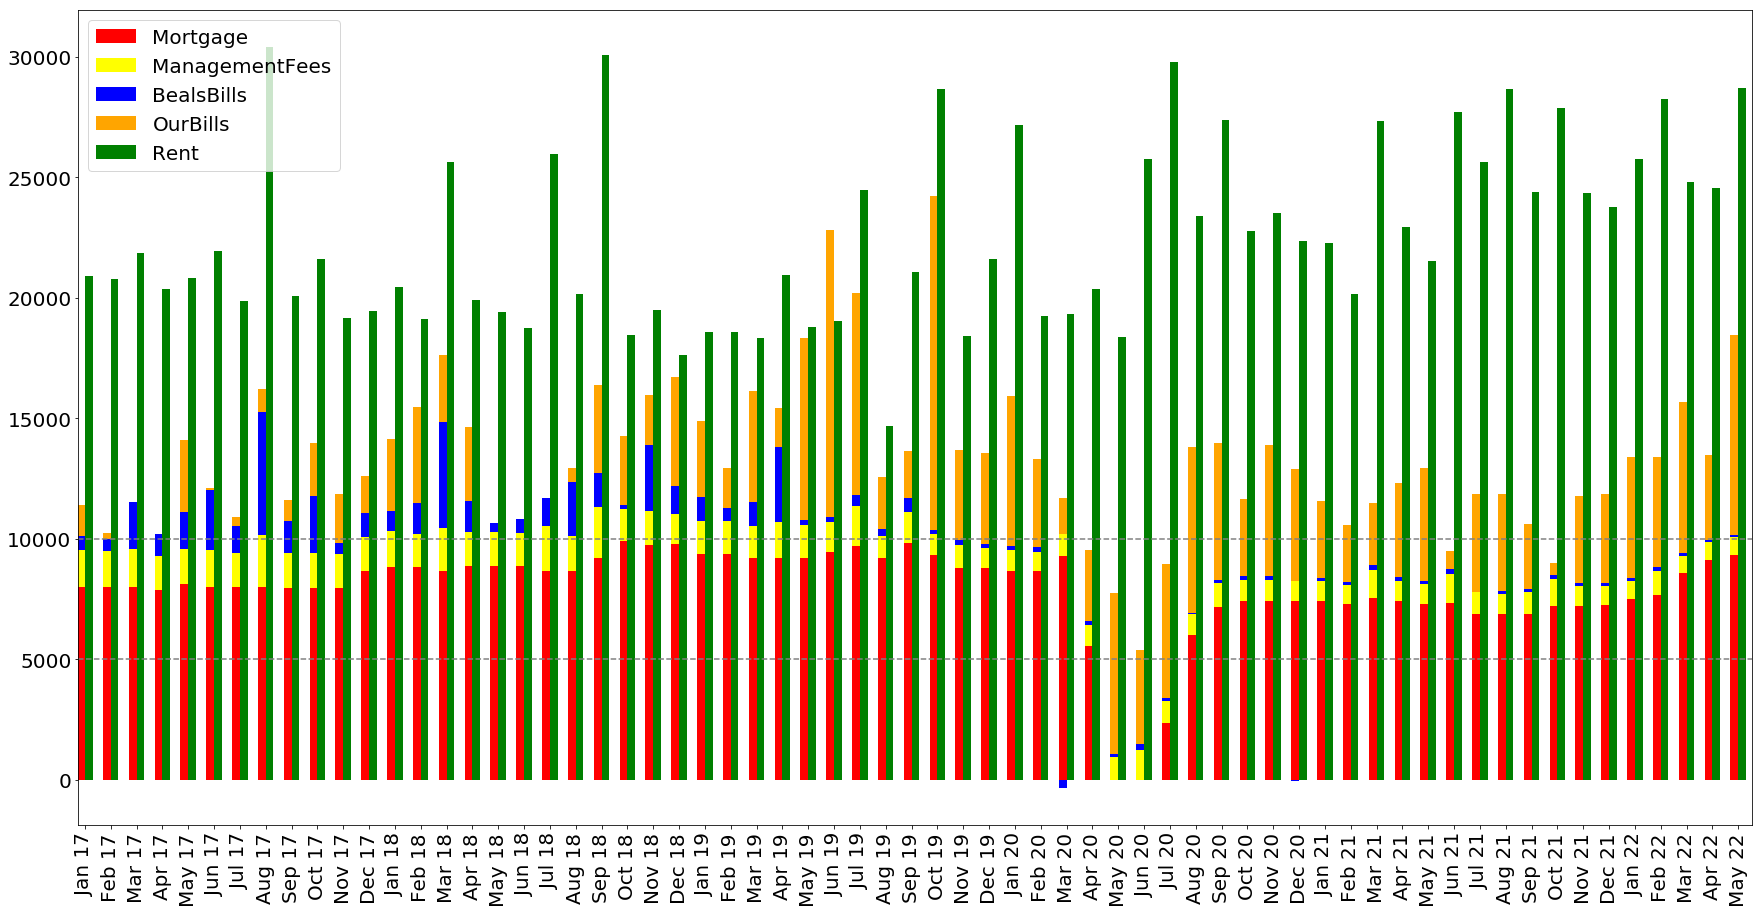

In [39]:
plot_rent_statement(dfSum,'2016-01-01','2022-05-31')

### Property Data Summary (from Bank data)

In [7]:
dfPty=get_pty_summary(dfMt,dfIv)
dfPty.tail(5)

,Mortgage,PropertyExpense,ServiceCharge,OurRent,BealsRent,TotalRent,NetProfit
Date,,,,,,,
2022-01-31,-7173.56,-5206.92,-1200.00,16695.0,7772.96,24467.96,10887.48
2022-02-28,-7319.32,-5200.57,-1200.00,15922.0,10688.95,26610.95,12891.06
2022-03-31,-8237.00,-6285.49,-1200.00,16070.0,8336.23,24406.23,8683.74
2022-04-30,-8795.64,-3523.02,-9632.72,15875.0,7434.03,23309.03,1357.65
2022-05-31,-8980.98,-8292.19,-1200.00,19483.0,7434.02,26917.02,8443.85


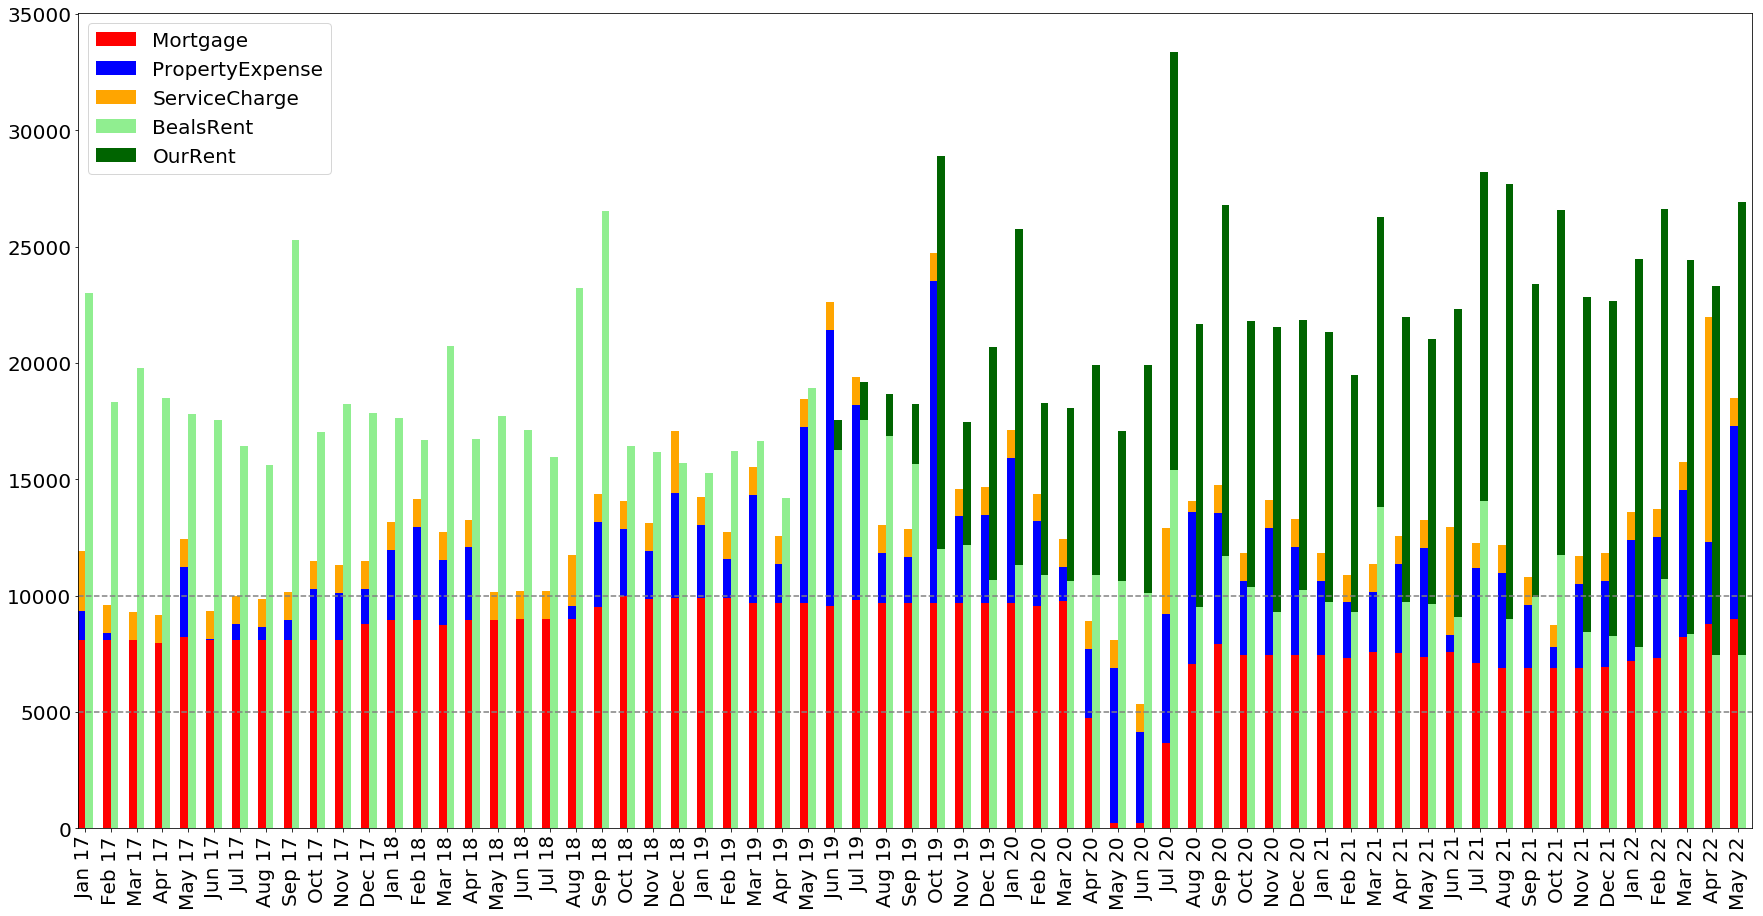

In [37]:
plot_properties(dfPty, '2016-01-01','2022-05-31')

## Outgoings Summary

In [9]:
dfOut=get_outgoings(dfPty,dfMt,dfIv,df40)
dfOut.tail(5)

,NetProfit,SchoolFee,Hilltop,Car,RegularPayment,PersonalExpense,HMRC,Other,TotalOutgoings,Profit
Date,,,,,,,,,,
2022-01-31,10887.48,-5419.56,-250.0,-366.23,-928.86,-4189.54,0.00,-573.85,-11154.19,-266.71
2022-02-28,12891.06,-5419.52,-250.0,-366.23,-902.56,-3200.00,0.00,-500.00,-10138.31,2752.75
2022-03-31,8683.74,-5419.52,-315.0,-366.23,-1397.20,-3542.11,-80902.86,27728.56,-11040.06,-2356.32
2022-04-30,1357.65,0.00,-300.0,-366.23,-1760.87,-4594.09,0.00,0.00,-7021.19,-5663.54
2022-05-31,8443.85,-5502.48,-300.0,-366.23,-2191.46,-4943.10,0.00,0.00,-13303.27,-4859.42


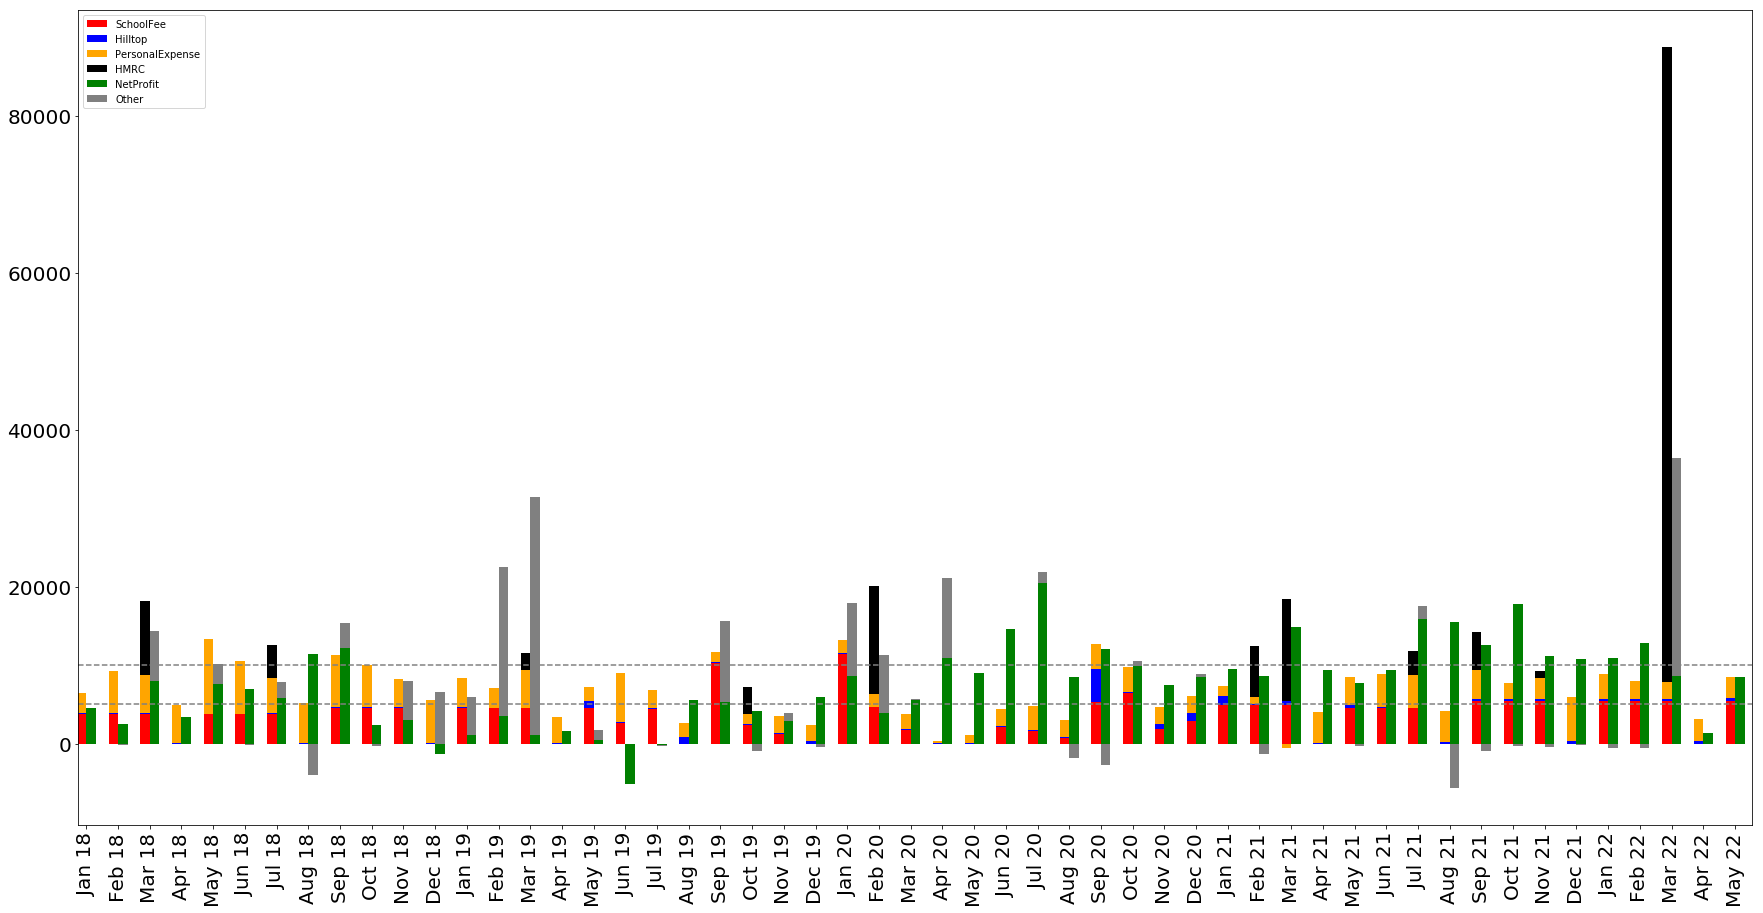

In [20]:
plot_outgoings(dfOut,'2018-01-01','2022-05-31')

## Personal Spending

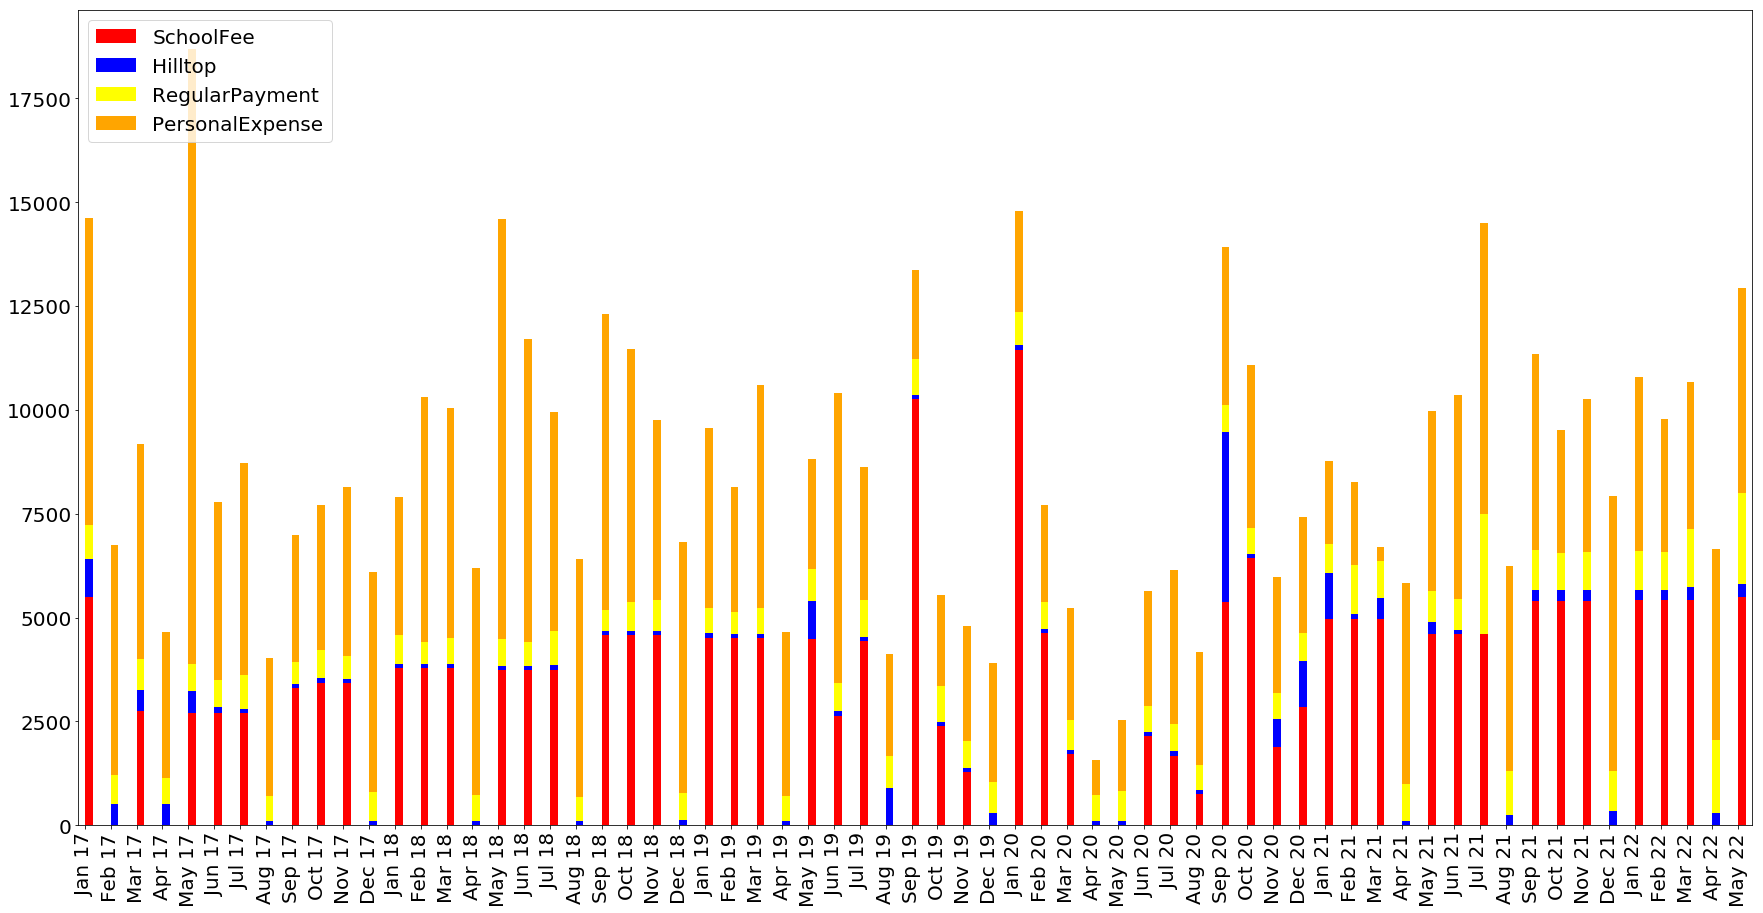

In [36]:
dfBar=pd.DataFrame()
start='2016-01-01'
end='2022-05-31'
dfBar['PersonalExpense'] = abs(dfOut.loc[start:end]['PersonalExpense'])
dfBar['RegularPayment'] = abs(dfOut.loc[start:end]['RegularPayment'])
dfBar['Hilltop'] = abs(dfOut.loc[start:end]['Hilltop'])
dfBar['SchoolFee'] = abs(dfOut.loc[start:end]['SchoolFee'])
dfBar.index = dfBar.index.strftime('%b %y')

#ax = dfBar[['PersonalExpense','RegularPayment','Hilltop','SchoolFee']].plot.bar(stacked=True, position=1, width=.3, color=['red','blue','orange','black'])
#=ax.axhline(5000, color="gray",linestyle='--')
#ax.axhline(10000, color="gray",linestyle='--')
dfBar[['SchoolFee','Hilltop','RegularPayment','PersonalExpense']].plot.bar(stacked=True, position=0, width=.3, color=['red','blue','yellow','orange'],figsize=(30,15),fontsize=20).legend(loc=2, prop={'size': 20})

## Categorisation Checks

In [12]:
dfMt.loc[(dfMt.Cat=='OtherIncome')].tail(5)
#dfIv.loc[(dfIv.Cat=='OtherIncome')]

,Account,Amount,Description,Memo,Property,Subcategory,Cat
Date,,,,,,,
2022-01-24,20-74-09 60458872,22.15,House,PAYPAL PPWDL5CM222223PQ6C BGC,NaN,DIRECTDEP,OtherIncome
2022-03-07,20-74-09 60458872,20728.56,Transfer from MT for Tax,M Tucker M TUCKER BGC,NaN,DIRECTDEP,OtherIncome
2022-03-21,20-74-09 60458872,5500.00,Payment from Natwest account for Tax,44FLITWICK NATWEST TRF MT REM,NaN,REM,OtherIncome
2022-03-21,20-74-09 60458872,2000.00,Transfer for Tax,M Tucker M TUCKER BGC,NaN,DIRECTDEP,OtherIncome
2022-04-12,20-74-09 60458872,463.47,Not sure - taken in March and refunded in April,PAYPAL PPWDL5CM222252CG8C BGC,NaN,DIRECTDEP,OtherIncome


In [42]:
dfOut.loc['2020-01-01':'2022-05-31']['SchoolFee'].sum()

-105580.64

## Save to csv

In [14]:
dfMt.to_csv('dfMt.csv')
dfIv.to_csv('dfIv.csv')
df40.to_csv('df40.csv')

In [15]:
# TODO: Make compatible with old Baker and Elder statements - difference 
# For personal spending - find where IV had sole use of bank card and to that point use funds transfered 6045->4040
# Fix categories for personal spending - i.e. Beals PAYMENT and FT for properties
# Check MAY18 Beals PAYMENT - this doesn't seem to be allocated to the properties
# Recheck all categories
# Allocate subcategories